In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ZGlobalLib.gpu_utils import use_gpu
use_gpu(1)

2023-12-15 14:41:28.870356: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 14:41:29.323167: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9651 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')

In [3]:
from histolungs import *

In [70]:
resolution = '20x'
class_type = 'macro'
exclude_pd = False

assert resolution in ['20x', '40x', None] # TODO add also the public dataset
assert class_type in ['micro', 'macro']

In [71]:
f = 0.3
1200*f, 1800*f

(360.0, 540.0)

## Get images

In [72]:
# Get paths and labels from private dataset
root_directory = "data/dataset_2_final/"
image_paths = get_files(root_directory, resolution=resolution, exclude_pd=exclude_pd)

In [73]:
random.shuffle(image_paths)

In [74]:
class_names, class2int, labels = get_classes_labels(root_directory, image_paths, class_type, exclude_pd=exclude_pd)

[2, 0, 1, 2, 0, 0, 2, 2]


In [75]:
num_classes = len(class2int)
train_generator, val_generator = get_generators(image_paths, labels, num_classes=num_classes, resolution=resolution, batch_size=8) 

In [76]:
class2int

{'aca': 0, 'nor': 1, 'scc': 2}

In [77]:
# train_generator = CustomDataGenerator(image_paths, labels, num_classes=num_classes, batch_size=8, shuffle_epoch=False)

In [78]:
image_paths[:8], labels[:8]

(['data/dataset_2_final/scc_bd/scc_bd_20x_65.jpg',
  'data/dataset_2_final/aca_bd/aca_bd_20x_546.jpg',
  'data/dataset_2_final/nor/nor_20x_53.jpg',
  'data/dataset_2_final/scc_md/scc_md_20x_2.jpg',
  'data/dataset_2_final/aca_md/aca_md_20x_4.jpg',
  'data/dataset_2_final/aca_md/aca_md_20x_3.jpg',
  'data/dataset_2_final/scc_md/scc_md_20x_4.jpg',
  'data/dataset_2_final/scc_md/scc_md_20x_662.jpg'],
 [2, 0, 1, 2, 0, 0, 2, 2])

/opt/miniconda/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


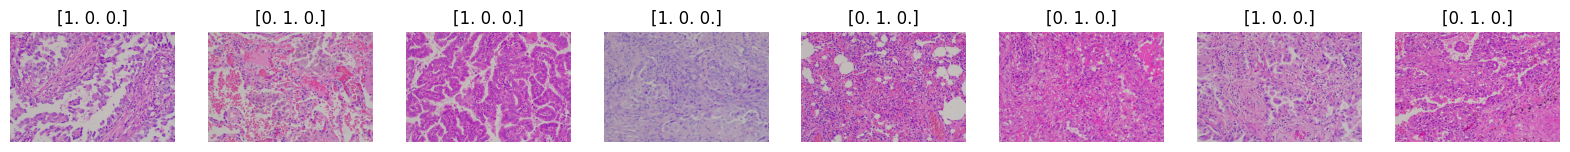

In [79]:
train_generator.show_generator()

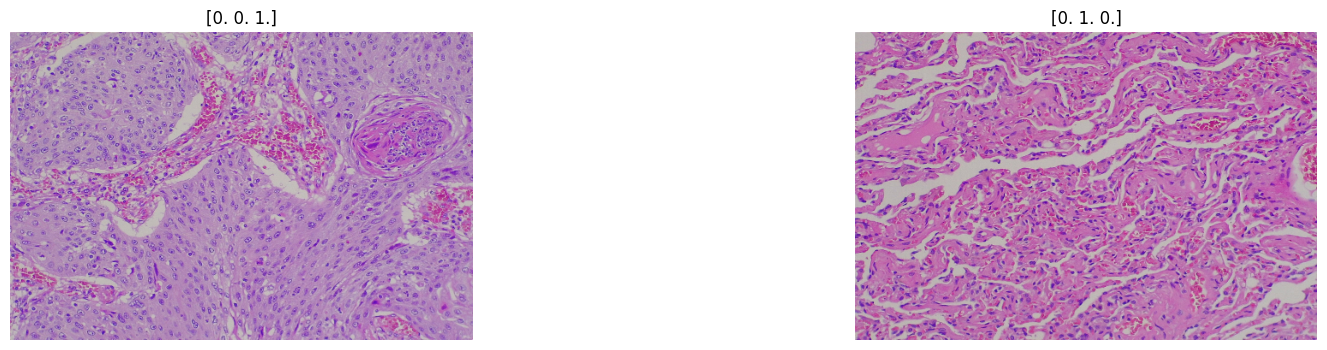

In [80]:
val_generator.show_generator()

In [81]:
class_weights = compute_weights(train_generator)
class_weights

  0%|          | 0/44 [00:00<?, ?it/s]

{0: 0.8250591016548463, 1: 1.8465608465608465, 2: 0.8022988505747126}

## Train EfficientNet-B0

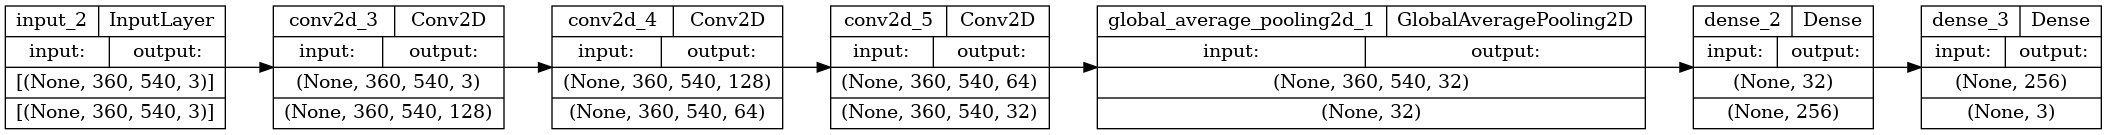

In [82]:
model = get_model(num_classes, resolution)
plot_model(model, rankdir='LR', show_shapes=True)

In [83]:
MODEL_NAME = 'Ef0_' + resolution
RUN_NAME = ''
log_dir = f'logs/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/{MODEL_NAME}{RUN_NAME}'
log_dir

'logs/20231215-155845/Ef0_20x'

In [84]:
#clear cache
# tf.keras.backend.clear_session()

In [85]:
# Train the model using the custom data generators and the debugging callback
history = train_model(model, train_generator, val_generator, num_classes, class_weights, log_dir)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



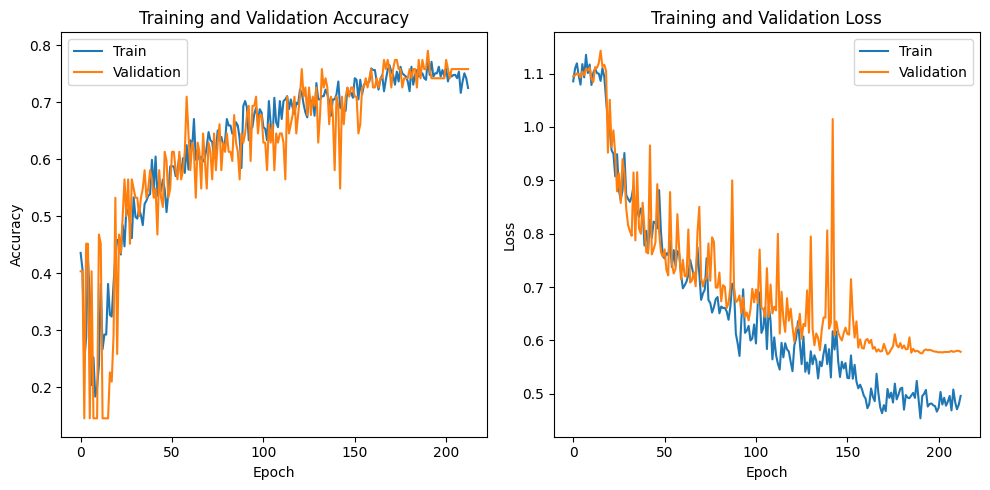

In [86]:
#Plot metrics
plot_metrics(history, log_dir)

## Evaluate using test data

In [87]:
test_directory = "data/validation_final_septiembre/"
test_generator = get_test_generator(class2int, resolution, log_dir, test_directory, exclude_pd)

Test Accuracy: 0.7741935483870968
Test Precision: 0.7996201329534663
Test Recall: 0.8010582010582011


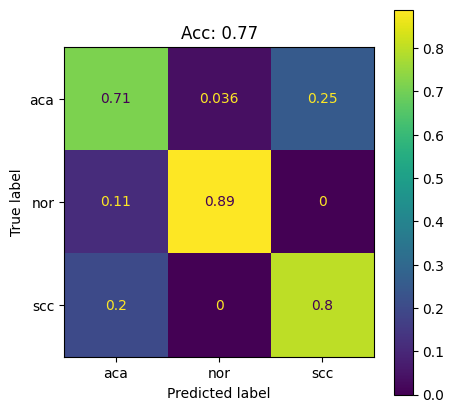

In [88]:
test_model(model, val_generator, log_dir, class_names)

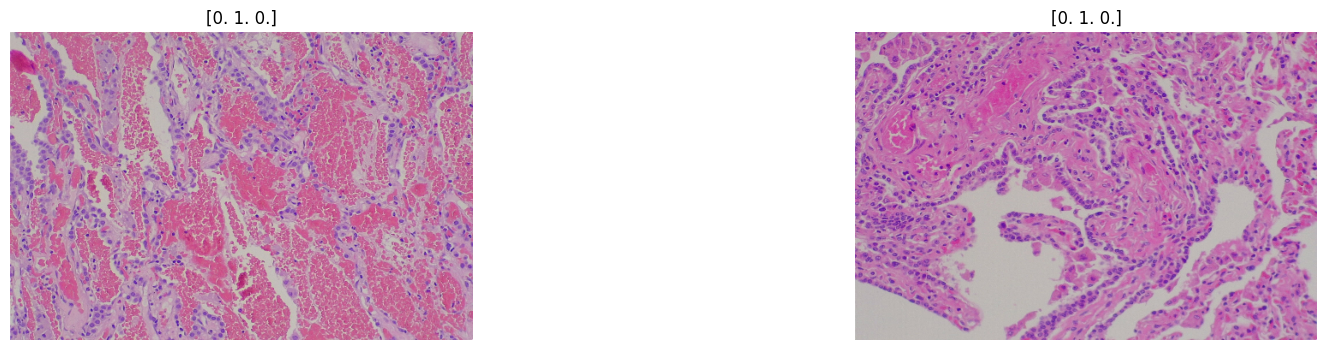

In [89]:
test_generator.show_generator()

In [90]:
model.summary()

Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 360, 540, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 360, 540, 128)     3584      
                                                                 
 conv2d_4 (Conv2D)           (None, 360, 540, 64)      73792     
                                                                 
 conv2d_5 (Conv2D)           (None, 360, 540, 32)      18464     
                                                                 
 global_average_pooling2d_1   (None, 32)               0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                          

In [91]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [95]:
from tensorflow import keras
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.utils.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.utils.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)/255
    return array

In [96]:
class2int

{'aca': 0, 'nor': 1, 'scc': 2}

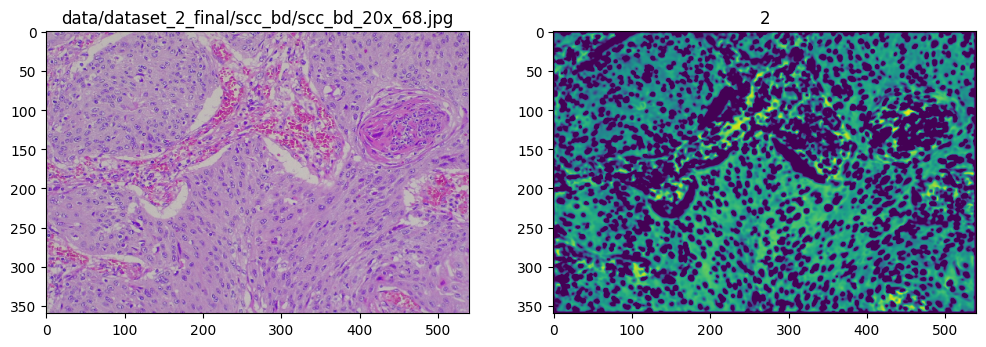

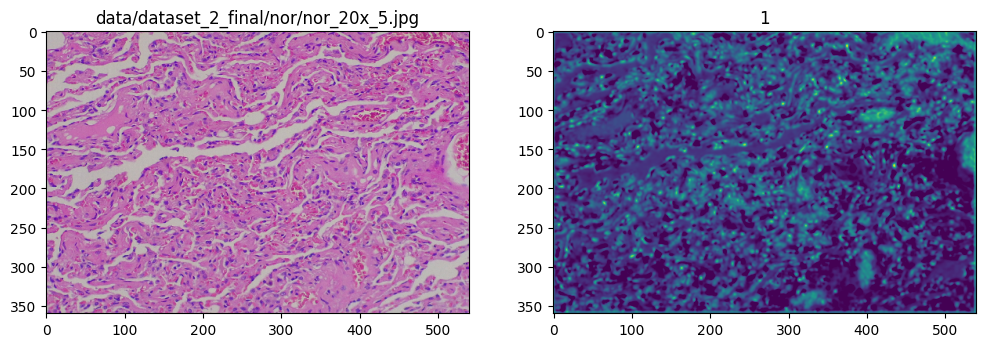

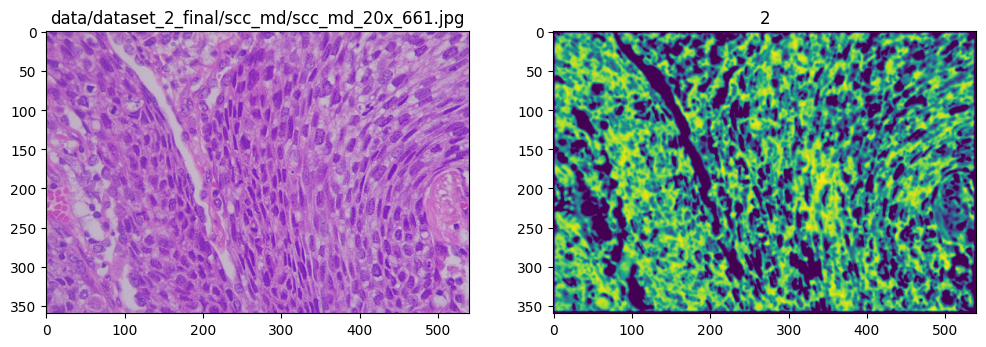

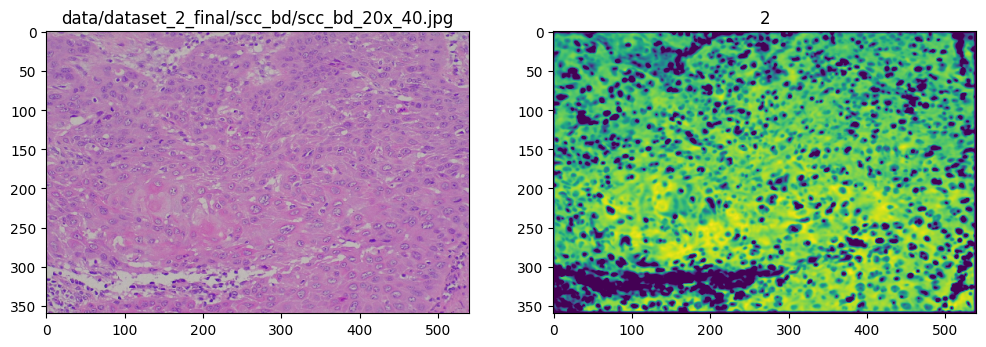

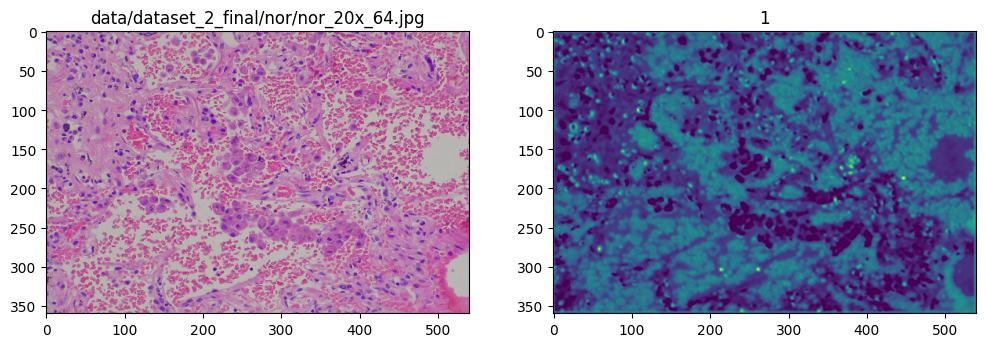

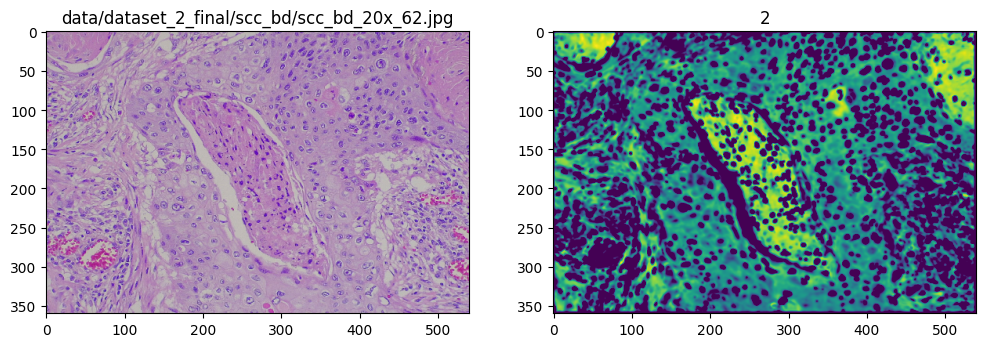

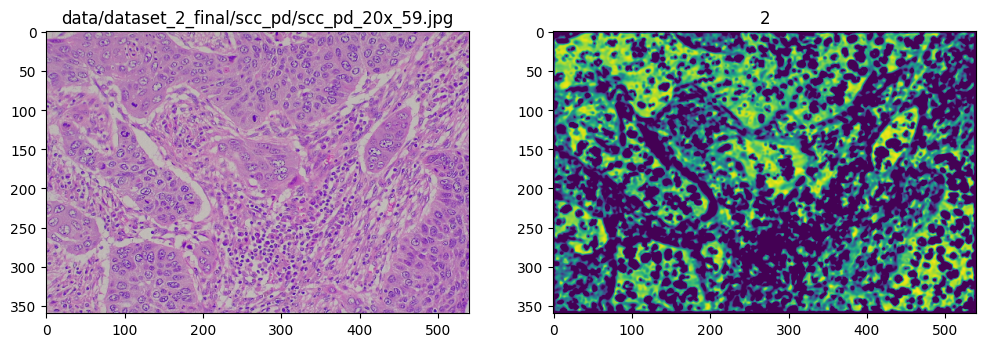

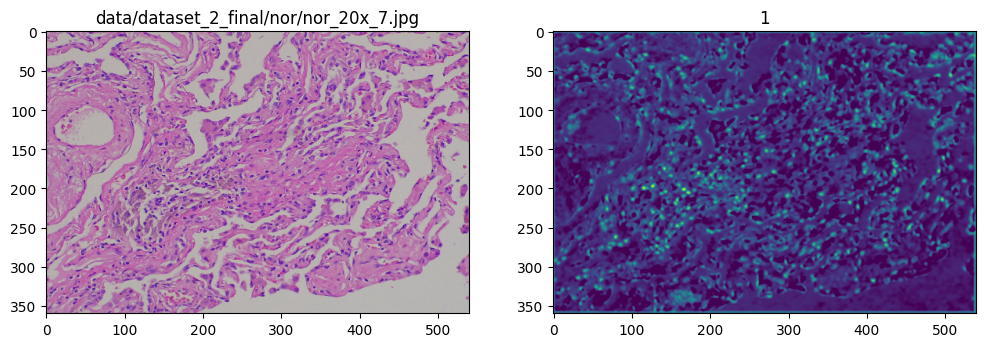

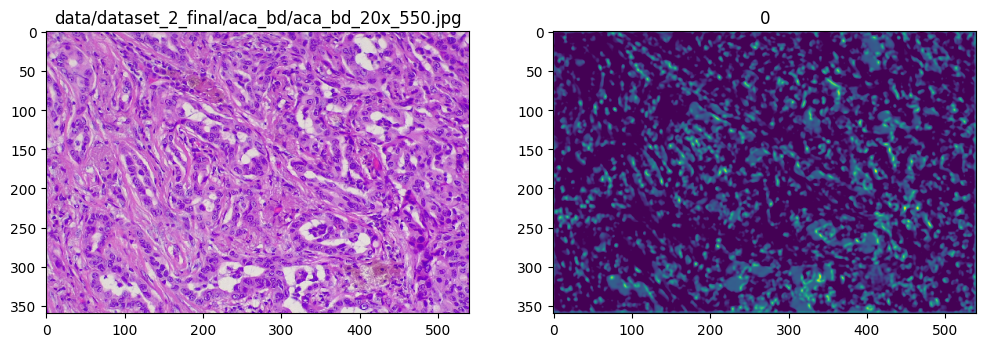

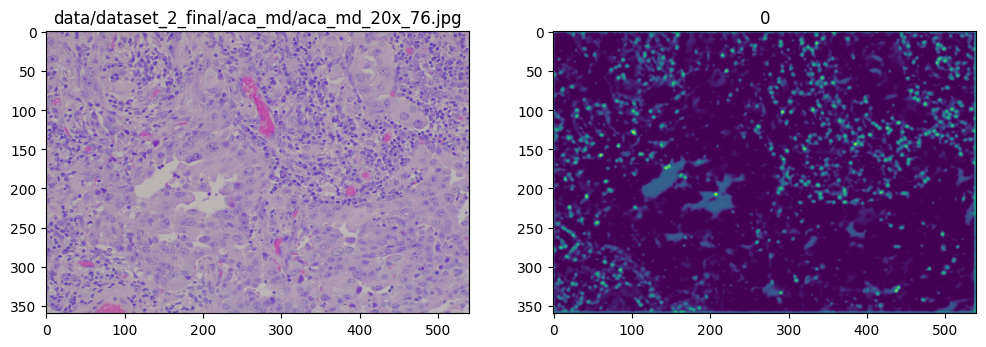

In [97]:
for i in range(10):
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    im = get_img_array(val_generator.images[i], (360, 540))
    axs[0].imshow(im[0]);
    axs[0].set_title(val_generator.images[i])
    heat = make_gradcam_heatmap(im, model, 'conv2d_5')
    axs[1].imshow(heat)
    axs[1].set_title(np.argmax(model.predict(im)[0]))
    plt.show()